In [5]:
import xgboost as xgb
import shap
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


def prepare_data(data, train_start='2017-03-21', test_start='2023-01-01', test_end='2023-03-01', target='F380 M2/M3'):
     # load data
    data.pricing_date = pd.to_datetime(data.pricing_date)
    data.set_index('pricing_date', inplace=True)

    # slice the dataset
    # data = data[data.index < non_consecutive_days(data[[target]])]
    data.interpolate(method='linear', inplace=True)
    
    data = data[(data.index >= train_start) & (data.index <= test_end)]
    data[target] = data[target].fillna(0)
    data.dropna(inplace=True)
    
    target_df = data[[target]]
    data.drop(columns=target, inplace=True)
    
    data = add_time_features(data)
    columns = drop_low_variance(data, test_start, test_end).tolist()
    columns += ['rolling_target5']
    
    # add rolling target
    data['rolling_target5'] = target_df.rolling(5).mean()
    data.dropna(inplace=True)
    
    return data[columns], target_df
    


def add_time_features(data):
    if 'year_sin' not in data.columns:
        data['year_sin'] = np.sin(data.index.year / data.index.year.max() * 2 * np.pi)

    if 'month_sin' not in data.columns:
        data['month_sin'] = np.sin(data.index.month / data.index.month.max() * 2 * np.pi)

    if 'day_sin' not in data.columns:
        data['day_sin'] = np.sin(data.index.day / data.index.day.max() * 2 * np.pi)
        
    if 'dow_sin' not in data.columns:
        data['dow_sin'] = np.sin(data.index.dayofweek / data.index.dayofweek.max() * 2 * np.pi)

    return data


def drop_low_variance(data, test_start, test_end, var=0.2):
    # remove rows after test start
    data = data[(data.index > '2017-03-21') & (data.index < test_start)]

    # check the length of prediction dates
    if len(data[(data.index >= test_start) & (data.index < test_end)]) < 100:
        return data.columns[data.var() > var]

    return data[['_rgp_01_sz_3', '_rgp_02_sz_3', '_rgp_03_sz_3', '_rgp_04_sz_3', '_rgp_05_sz_3',
                 'BPSG', 'COASTAL', 'GUNVORSG', 'HL', 'MERCURIASG', 'P66SG', 'PETROCHINA',
                 'SIETCO', 'TOTALSG', 'TRAFI', 'VITOLSG']].columns

In [6]:
results_with_ma = pd.read_csv('experiments/2024-01-11/results-for-2023-01-01-2023-03-01.csv')
results_wo_ma = pd.read_csv('experiments/2024-01-23/results-for-2023-01-01-2023-03-01.csv')

orig_data = pd.read_csv('data/data_2024-01-23.csv')
orig_data, target = prepare_data(orig_data)

TARGET_VALS = target.copy()
orig_data


,ALVARI,ARAMCOSG,ARAMCOTF,ARCENERGY,BBEN,BPSG,BRIGHTOILSG,BUYER1,BUYER2,CAOSG,...,_rgp_06_sz_3,_rgp_07_sz_3,_rgp_08_sz_3,_rgp_09_sz_3,_rgp_10_sz_3,_rgp_11_sz_3,month_sin,day_sin,dow_sin,rolling_target5
pricing_date,,,,,,,,,,,,,,,,,,,,,
2017-03-27,0.0,0.0,0.0,0.0,0.0,10.390244,0.0,0.0,0.0,9.253605,...,1673.333333,3636.666667,0.000000,0.0,0.0,0.0,1.000000,-7.247928e-01,0.000000e+00,-0.06
2017-03-28,0.0,0.0,0.0,0.0,0.0,9.328589,0.0,0.0,0.0,7.814089,...,1673.333333,3586.666667,0.000000,0.0,0.0,0.0,1.000000,-5.712682e-01,1.000000e+00,-0.04
2017-03-29,0.0,0.0,0.0,0.0,0.0,9.328589,0.0,0.0,0.0,7.291213,...,1673.333333,3346.666667,0.000000,0.0,0.0,0.0,1.000000,-3.943559e-01,1.224647e-16,-0.09
2017-03-30,0.0,0.0,0.0,0.0,0.0,6.643773,0.0,0.0,0.0,7.291213,...,1673.333333,3346.666667,0.000000,0.0,0.0,0.0,1.000000,-2.012985e-01,-1.000000e+00,-0.13
2017-03-31,0.0,0.0,0.0,0.0,0.0,9.359076,0.0,0.0,0.0,6.240409,...,1040.000000,2440.000000,0.000000,0.0,0.0,0.0,1.000000,-2.449294e-16,-2.449294e-16,-0.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-23,0.0,0.0,0.0,0.0,0.0,3.915344,0.0,0.0,0.0,0.000000,...,-300.000000,-70.000000,-81.666667,0.0,0.0,0.0,0.866025,-9.987165e-01,-1.000000e+00,2.25
2023-02-24,0.0,0.0,0.0,0.0,0.0,4.285714,0.0,0.0,0.0,0.000000,...,-545.000000,-340.000000,-491.666667,0.0,0.0,0.0,0.866025,-9.884683e-01,-2.449294e-16,2.37
2023-02-27,0.0,0.0,0.0,0.0,0.0,4.430556,0.0,0.0,0.0,0.000000,...,-695.000000,-123.333333,-970.000000,0.0,0.0,0.0,0.866025,-7.247928e-01,0.000000e+00,2.39


In [50]:
model_without_ma = xgb.Booster()
model_without_ma.load_model('experiments/models/train_without_ma.model')

model_with_ma = xgb.Booster()
model_with_ma.load_model('experiments/models/train-until-2023_variance=0.2_col_length=68.model')

In [8]:
orig_wo_ma = orig_data.copy().drop(columns='rolling_target5')
orig_with_ma = orig_data.copy()

print(orig_wo_ma.shape)
print(orig_with_ma.shape)

(1548, 68)
(1548, 69)


In [47]:
orig_wo_ma = orig_wo_ma[orig_wo_ma.index <= '2023-03-01']
orig_with_ma = orig_with_ma[orig_with_ma.index <= '2023-03-01']

In [48]:
from sklearn.model_selection import train_test_split

def f_wo_ma(x):
    return model_without_ma.predict(x)


def f_with_ma(x):
    return model_with_ma.predict(x)


In [49]:
import matplotlib
from IPython.core.display import display, HTML

def get_shap_values(df, model, type='default'):
    if type == 'default':
        explainer = shap.TreeExplainer(model)
        return explainer, explainer.shap_values(df)
    
    explainer = shap.Explainer(model)
    return explainer(df)

def show_force_plot(df, model):
    explainer, shap_values = get_shap_values(df, model)
    shap.force_plot(explainer.expected_value, shap_values[0, :], df.iloc[0, :], matplotlib=matplotlib)


def show_timeseries(df, model):
    explainer, shap_values = get_shap_values(df, model)
    plot = shap.force_plot(explainer.expected_value, shap_values[-200:, :], df.iloc[-200:, :], matplotlib=False)
    shap_html = f'{shap.getjs()}{plot.html()}'
    display(HTML(shap_html))


def summary_plot(df, model):
    explainer, shap_values = get_shap_values(df, model)
    shap.summary_plot(shap_values, df, plot_type='bar')
    

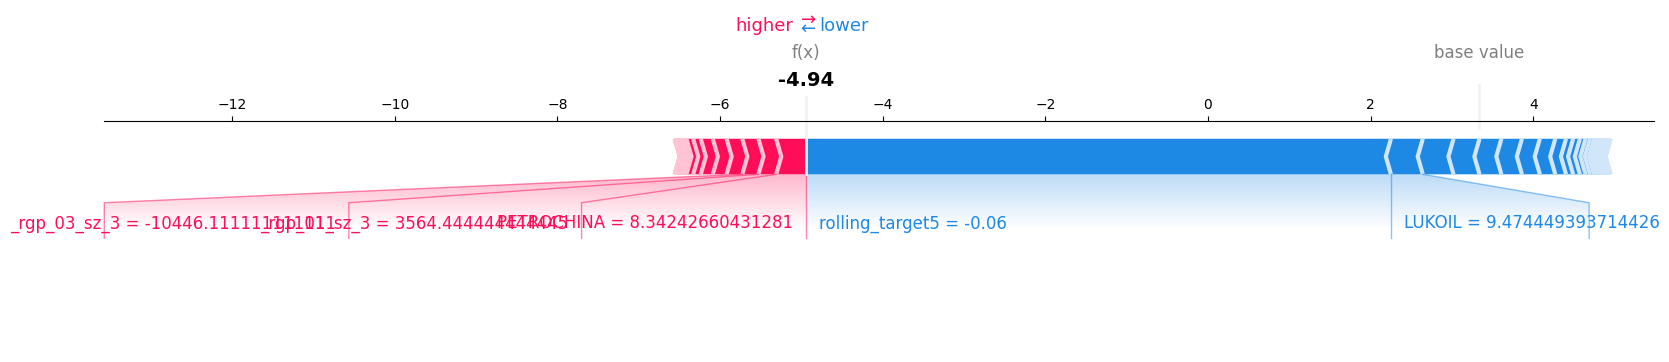

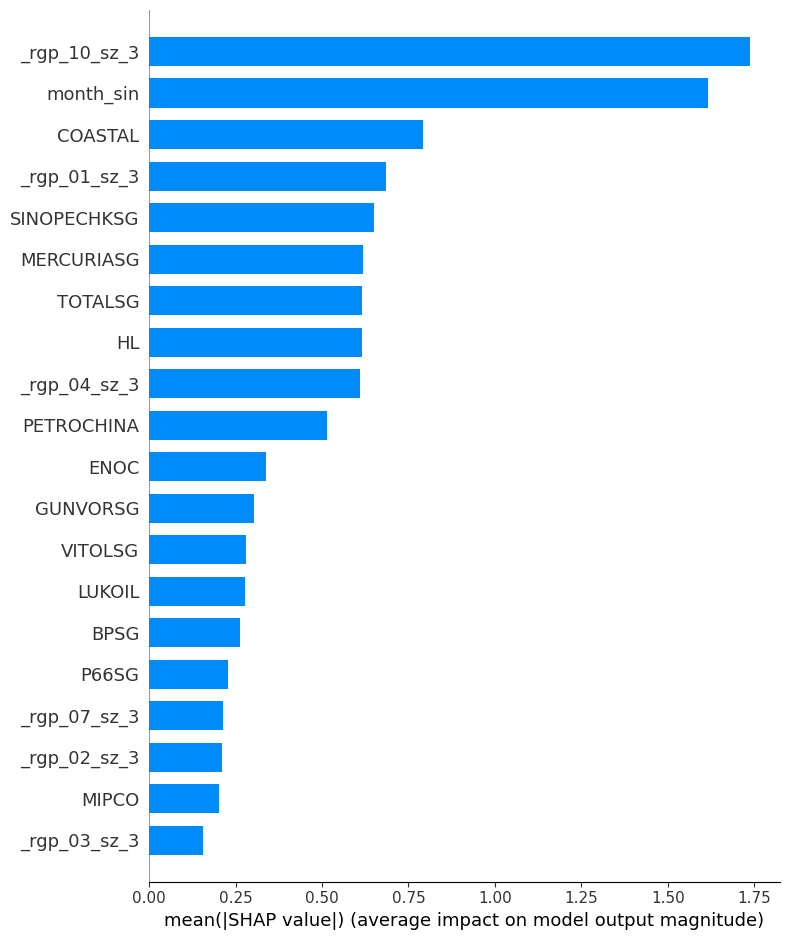

In [15]:
show_force_plot(orig_with_ma, model_with_ma)
show_timeseries(orig_wo_ma, model_without_ma)
summary_plot(orig_wo_ma, model_without_ma)

In [20]:
import plotly.express as px
import plotly.graph_objects as go

def get_colors(values):
    return ['green' if v >= 0 else 'red' for v in values]


def create_waterfall(df, model, idx):
    explainer, shap_values = get_shap_values(df, model)

    features = pd.DataFrame({'column': df.drop(columns='F380 M2/M3').columns, 'value': shap_values[idx].values})
    features['abs_value'] = features['value'].abs()
    sort = features.sort_values('abs_value', ascending=False).head(10)[['column', 'value']]

    fig = go.Figure(go.Bar(x=sort['value'], y=sort['column'], orientation='h', marker=dict(color=get_colors(sort.value.tolist()))))
    fig.update_xaxes(range=[-5, 5])
    return fig


In [17]:
import os
import re
import pandas as pd
import panel as pn
import param
import os
import holoviews as hv

import pandas as pd
import plotly.graph_objects as go

# perspective packages
import pickle
from pathlib import Path
import datetime as dt

pn.config.js_files["jquery"]="https://code.jquery.com/jquery-1.12.4.min.js"
pn.config.js_files["sparkline"]="https://cdnjs.cloudflare.com/ajax/libs/jquery-sparklines/2.1.2/jquery.sparkline.min.js"

pn.extension('tabulator', 'plotly', 'ipywidgets', 'perspective',  css_files=[pn.io.resources.CSS_URLS['font-awesome']], sizing_mode='stretch_width', omms='ipywidgets')

pn.config.js_files["sparkline_to_tabulator"]="https://cdn.jsdelivr.net/gh/MarcSkovMadsen/awesome-panel-assets@master/js/add_spark_lines_to_tabulator.min.js"


In [18]:
def custom_pnl_10(y_pred, y_true):
    nth = len(y_pred)

    thresh = 0.2
    
    try:
        diff = y_pred[-1] - y_pred[0]
    except IndexError:
        diff = y_pred[-1] - y_pred[0]

    direction = 1 if diff > thresh else (-1 if diff < thresh else 0)
    pnl = diff * direction

    return 'pnl', pnl


def get_preds(preds, date):
    preds_df = preds.copy()
    preds_df = preds_df[preds_df['forecast_date'] == date]

    if 'index' in preds_df.columns:
        idx = np.unique(preds_df['index'], return_index=True)[1]
    else:
        idx = np.unique(preds_df.index, return_index=True)[1]
    return preds_df.iloc[idx]

In [58]:
def get_preds_df(path):
    preds = pd.read_csv(path, index_col=0)
    preds.set_index('pricing_date', inplace=True)
    preds.index = pd.to_datetime(preds.index)
    preds.drop(columns='target', inplace=True)
    return preds


preds_wo_ma = get_preds_df('experiments/2024-01-23/results-for-2023-01-01-2023-03-01.csv')
preds_with_ma = get_preds_df('experiments/2024-01-11/results-for-2023-01-01-2023-03-01.csv')
wo_ma_shap = get_shap_values(orig_wo_ma.drop(columns='F380 M2/M3'), model_without_ma, type='explainer')
with_ma_shap = get_shap_values(orig_with_ma, model_with_ma,  type='explainer')


In [65]:
from datetime import datetime, timedelta

def get_dates_between(start_date_str, end_date_str):
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")
    
    # Calculate the difference between end_date and start_date
    delta = end_date - start_date
    
    # Generate a list of dates within the specified range
    date_list = [start_date + timedelta(days=i) for i in range(delta.days + 1)]
    
    # Format the dates as strings
    formatted_dates = [date.strftime("%Y-%m-%d") for date in date_list]
    
    return formatted_dates

In [109]:
import param
import numpy as np
import panel as pn
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
import holoviews as hv
import hvplot.pandas
# from datetime import strptime
pn.extension(sizing_mode="stretch_width")

SELECTED_RANGE = None

forecast_dates = sorted(list(preds_wo_ma['forecast_date'].unique()))
dates = preds_wo_ma.forecast_date.unique()
available_dates = get_dates_between(dates[0], dates[-1])
excluded_dates = [x for x in available_dates if x not in dates]
excluded_dates

def create_waterfall(df, model, idx=0, shap_values=None):
    if shap_values is None:
        explainer = shap.Explainer(model)
        shap_values = explainer(df)
    
    features = pd.DataFrame({'column': df.drop(columns='F380 M2/M3').columns, 'value': shap_values[idx]})
    features['abs_value'] = features['value'].abs()
    sort = features.sort_values('abs_value', ascending=False).head(10)[['column', 'value']]

    fig = go.Figure(go.Bar(x=sort['value'], y=sort['column'], orientation='h', marker=dict(color=get_colors(sort.value.tolist()))))
    fig.update_xaxes(range=[-5, 5])
    return fig

class Model(param.Parameterized):
    format_date = lambda x: [int(y) for y in x.split('-')]
    start_date, end_date = dt.datetime(*format_date(forecast_dates[0])), dt.datetime(*format_date(forecast_dates[-1]))
    values = (start_date, end_date)
    period = param.DateRange(default=values, bounds=(start_date, end_date))

def select_available_dates(values):
    available = []

    for option in checkboxes.values:
        opt = datetime(*[int(x) for x in option.split('-')])
        if values[0] <= opt <= values[1]:
            available.append(option)
            
    return available

def out(value):
    checkboxes.value = select_available_dates(value)
    
todate = lambda x: datetime.strptime(x, '%Y-%m-%d')

model = Model()
checkboxes = pn.widgets.CheckBoxGroup(name='Checkbox Group', value=[forecast_dates[0]], options=forecast_dates, inline=False, margin=(20, 10, 10, 10))

target2 = target.copy()
orig_wo_ma['F380 M2/M3'] = target2[4:]
orig_with_ma['F380 M2/M3'] = target2[4:]

select = get_preds(preds_wo_ma, forecast_dates[0])
target4 = orig_wo_ma[(orig_wo_ma.index >= select.index.min()) & (orig_wo_ma.index <= select.index.max())]['F380 M2/M3']
select['target'] = target4.values
TARGETS = {}
date_picker = pn.widgets.DatePicker(value=preds_wo_ma.index.min().date(), start=preds_wo_ma.index.min().date(), 
                                    end=preds_wo_ma.index.max().date(), disabled_dates=excluded_dates)

def create_pnl(df_copy):
    results = {}

    uniq = df_copy.forecast_date.unique()

    for date in uniq:
        d = df_copy[df_copy.forecast_date == date]
        res = custom_pnl_10(d.preds.values, d.target.values)

        if any(TARGETS[date].target.isna().tolist()):
            results[date] = 'unknown'
        else:
            results[date] = res[1]

    return pd.DataFrame(results.values(), index=results.keys(), columns=['pnl'])


@pn.depends(date_picker.param.value)
def update_pnl_df(sel):
    slices = orig_wo_ma[(orig_wo_ma.index >= SELECTED_RANGE.pricing_date.min()) & (orig_wo_ma.index <= SELECTED_RANGE.pricing_date.max())]
    idx = len(orig_wo_ma[orig_wo_ma.index < SELECTED_RANGE.pricing_date.max()]) - 1
    
    print(idx)
    return create_waterfall(orig_wo_ma, model_without_ma, idx=idx, shap_values=wo_ma_shap.values)
    

@pn.depends(date_picker.param.value)
def update_plot(selected):
    global SELECTED_RANGE, dataframe
    
    sel = preds_wo_ma['forecast_date'].apply(lambda x: x in [str(selected)])
    selected_range = preds_wo_ma[sel]
    selected_range.reset_index(inplace=True)
    SELECTED_RANGE = selected_range
    
    SELECTED_RANGE['target'] = None

    fig = go.Figure()
    
    for unique_date in selected_range.forecast_date.unique():
        select = get_preds(selected_range, unique_date)
        fig.add_trace(go.Scatter(x=select.pricing_date, y=select.preds, name='Preds:' + unique_date, connectgaps=False))
        
        # get real target values 
        target2 = TARGET_VALS.copy()
        target3 = target2[(target2.index >= select.pricing_date.min())][:10]
        
        fig.add_trace(go.Scatter(x=target3.index, y=target3['F380 M2/M3'].values, name='Hist:' + unique_date, connectgaps=False, line=dict(color='red')))
        TARGETS[unique_date] = target3

    fig.update_layout(title='DataFrame w/o rolling')
    return fig


@pn.depends(date_picker.param.value)
def update_pnl_df2(sel):
    slices = orig_with_ma[(orig_with_ma.index >= SELECTED_RANGE.pricing_date.min()) & (orig_with_ma.index <= SELECTED_RANGE.pricing_date.max())]
    idx = len(orig_with_ma[orig_with_ma.index < SELECTED_RANGE.pricing_date.max()]) - 1
    
    print(idx)
    return create_waterfall(orig_with_ma, model_with_ma, idx=idx, shap_values=with_ma_shap.values)
    

@pn.depends(date_picker.param.value)
def update_plot2(selected):
    global SELECTED_RANGE, dataframe
    
    sel = preds_with_ma['forecast_date'].apply(lambda x: x in [str(selected)])
    selected_range = preds_with_ma[sel]
    selected_range.reset_index(inplace=True)
    SELECTED_RANGE = selected_range
    
    SELECTED_RANGE['target'] = None

    fig = go.Figure()
    
    for unique_date in selected_range.forecast_date.unique():
        select = get_preds(selected_range, unique_date)
        fig.add_trace(go.Scatter(x=select.pricing_date, y=select.preds, name='Preds:' + unique_date, connectgaps=False))
        
        # get real target values 
        to_plot = TARGETS[unique_date]
        print('to plot:', to_plot)
        print(to_plot.index, to_plot.values)
        fig.add_trace(go.Scatter(x=to_plot.index, y=to_plot['F380 M2/M3'].values, name='Hist:' + unique_date, connectgaps=False, line=dict(color='red')))
        # target2 = TARGET_VALS.copy()
        # target3 = target2[(target2.index >= select.pricing_date.min())][:10]
        
        # fig.add_trace(go.Scatter(x=target3.index, y=target3['F380 M2/M3'].values, name='Hist:' + unique_date, connectgaps=False, line=dict(color='red')))
        # TARGETS[unique_date] = target3

    fig.update_layout(title='DataFrame with rolling')
    return fig

# widget = pn.WidgetBox(pn.Row(pn.Column(update_plot, width=1000), pn.Column(update_pnl_df, width=500), sizing_mode="stretch_both"), 
#                       date_picker,
#                       pn.Row(pn.Column(update_plot2, width=1000), pn.Column(update_pnl_df2, width=500), sizing_mode="stretch_both"))

main = pn.template.FastGridTemplate(prevent_collision=True)
main.main[:, :] = pn.Column(
    pn.Row(pn.Column(update_plot, width=1100, height=400), pn.Column(update_pnl_df, width=600, height=400)),
    date_picker,
    pn.Row(pn.Column(update_plot2, width=1100, height=400), pn.Column(update_pnl_df2, width=600, height=400))
)
# main.main[:2, :12] = pn.Row(pn.Column(update_plot, width=1100, height=400), pn.Column(update_pnl_df, width=600, height=400))
# main.main[3, :] = date_picker

main.show()

1513
to plot:               F380 M2/M3
pricing_date            
2023-01-02          0.50
2023-01-03         -0.50
2023-01-04         -1.00
2023-01-05         -1.10
2023-01-06         -0.75
2023-01-09         -0.75
2023-01-10         -0.75
2023-01-11         -1.00
2023-01-12         -2.00
2023-01-13         -1.75
DatetimeIndex(['2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05',
               '2023-01-06', '2023-01-09', '2023-01-10', '2023-01-11',
               '2023-01-12', '2023-01-13'],
              dtype='datetime64[ns]', name='pricing_date', freq=None) [[ 0.5 ]
 [-0.5 ]
 [-1.  ]
 [-1.1 ]
 [-0.75]
 [-0.75]
 [-0.75]
 [-1.  ]
 [-2.  ]
 [-1.75]]
1513
Launching server at http://localhost:65244


1526
to plot:               F380 M2/M3
pricing_date            
2023-01-19      0.000000
2023-01-20      0.400000
2023-01-23      0.766667
2023-01-24      1.133333
2023-01-25      1.500000
2023-01-26      1.750000
2023-01-27      2.250000
2023-01-30      1.750000
2023-01-31      1.500000
2023-02-01      1.500000
DatetimeIndex(['2023-01-19', '2023-01-20', '2023-01-23', '2023-01-24',
               '2023-01-25', '2023-01-26', '2023-01-27', '2023-01-30',
               '2023-01-31', '2023-02-01'],
              dtype='datetime64[ns]', name='pricing_date', freq=None) [[0.        ]
 [0.4       ]
 [0.76666667]
 [1.13333333]
 [1.5       ]
 [1.75      ]
 [2.25      ]
 [1.75      ]
 [1.5       ]
 [1.5       ]]
1526
1546
to plot:               F380 M2/M3
pricing_date            
2023-02-16          2.35
2023-02-17          1.70
2023-02-20          2.20
2023-02-21          2.20
2023-02-22          2.75
2023-02-23          2.40
2023-02-24          2.30
2023-02-27          2.30
2023-02-28          